In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split
#statsmodels.tsa.stattools.acf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [3]:
#importamos y limpiamos datos
P=pd.read_csv("C:/Users/manut/Downloads/AGUAC.csv",sep=";")
P.head()
from datetime import datetime
P['DATE'] = P.DATE.map(lambda x : datetime.strptime(x, '%m-%Y'))
P.index=P.DATE
del(P["DATE"])
#P

,P
DATE,
2005-01-01,114.870000
2005-02-01,108.526149
2005-03-01,131.026229
2005-04-01,92.641992
2005-05-01,145.609327
...,...
2017-08-01,255.500000
2017-09-01,150.000000
2017-10-01,138.670000


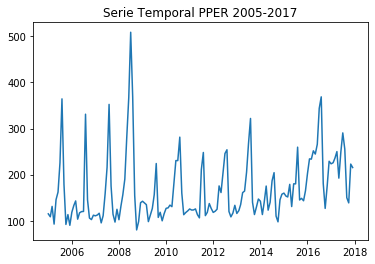

In [4]:
#Gráfico de la serie temporal
plt.plot(P)
plt.title("Serie Temporal PPER 2005-2017")
plt.show()

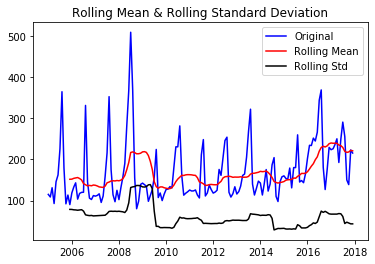

In [5]:
#TENDENCIA MEDIA Y STD
rolling_mean = P.rolling(window = 12).mean()
rolling_std = P.rolling(window = 12).std()
plt.plot(P, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

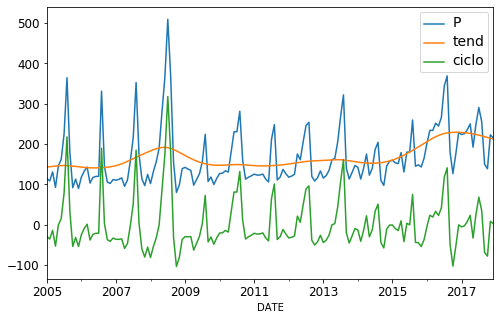

In [6]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
P_ciclo, P_tend = sm.tsa.filters.hpfilter(P['P'])
P['tend'] =P_tend
P["ciclo"]=P_ciclo
P[['P', 'tend',"ciclo"]].plot(figsize=(8, 5), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);

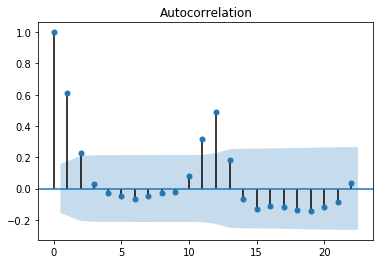

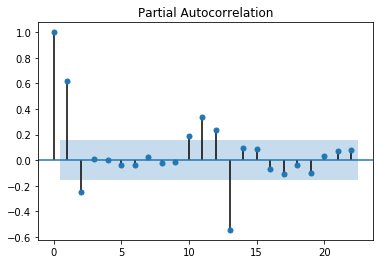

In [8]:
#CORRELOGRAMA
plot_acf(P.P)
plot_pacf(P.P)
plt.show()
#Correlograma: El correlograma no nos da signos de que la serie no sea estacionaria en media,
# más bien de que sigue algún tipo de modelo ARIMA con comportamiento estacional.

In [9]:
#TEST DICKEY FULLER
result = adfuller(P['P'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
    
#H0: Existe una raíz unitaria vs H1: Ausencia de raíz unitaria
#P valor = 0.06685 => Con un 95% de confianza no podemos rechazar la existencia de una raíz
#unitaria, pero si podemos hacerlo con un 90% de confianza
#• Como hay dudas con el contraste ADF, rechazaremos la hipótesis de que existe una raíz
#unitaria en base al análisis del correlograma. Por lo que no vamos a aplicar diferencias
#regulares para estimar el modelo.
#En el correlograma apreciamos un decrecimiento sinusoidal en la FAC, con las dos primeras
#correlaciones significativas (¿AR (2)?), además de comportamiento estacional (parece que hay
#que aplicar diferencias estacionales)    

ADF Statistic: -2.7428833436475646
p-value: 0.0669069699914809
Critical Values:
	1%: -3.4769274060112707
	5%: -2.8819726324025625
	10%: -2.577665408088415


C:\Users\manut\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


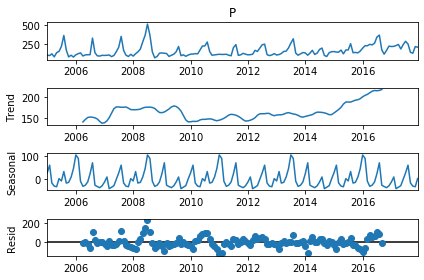

In [10]:
#Descomposición en tendencia, estacionalidad y residuos
descomposicion = sm.tsa.seasonal_decompose(P["P"],
                                                  model='additive', freq=30)  
fig = descomposicion.plot()

In [11]:
#Importamos modulo auto_arima de libreria pmdarima (pyramid.arima) para efectuar la estimación automática del modelo
from pmdarima import auto_arima
stepwise_model = auto_arima(P["P"], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1458.706, Time=2.21 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1523.297, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1498.640, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1472.472, Time=1.08 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1460.643, Time=5.15 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1460.595, Time=14.09 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=2.55 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=17.90 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1472.593, Time=0.84 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1459.635, Time=2.07 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=1.61 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1471.233, Time=0.42 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1471.738, Time=1.13 sec
 ARIMA(2,1,0)(0,1,1)[12]             

In [92]:
#Otra manera de estimar el modelo sin importar el módulo auto.arima
#for param in pdq:
#    for param_seasonal in seasonal_pdq:
#        try:
#            mod = sm.tsa.statespace.SARIMAX(P.P,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
#            results = mod.fit()
#            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
##        except: 
#            continue

In [14]:
#El test AIC nos indica que el mejor modelo es una ARIMA (1,1,1)*(0,1,1)12 con AIC=1458.706
mod = sm.tsa.statespace.SARIMAX(P.P,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12)
                                )
results = mod.fit()
print(results.summary().tables[1])

C:\Users\manut\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\manut\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7188      0.033     21.948      0.000       0.655       0.783
ma.L1         -0.9839      0.062    -15.811      0.000      -1.106      -0.862
ma.S.L12      -0.7167      0.094     -7.603      0.000      -0.901      -0.532
sigma2      1370.4525    123.454     11.101      0.000    1128.487    1612.418


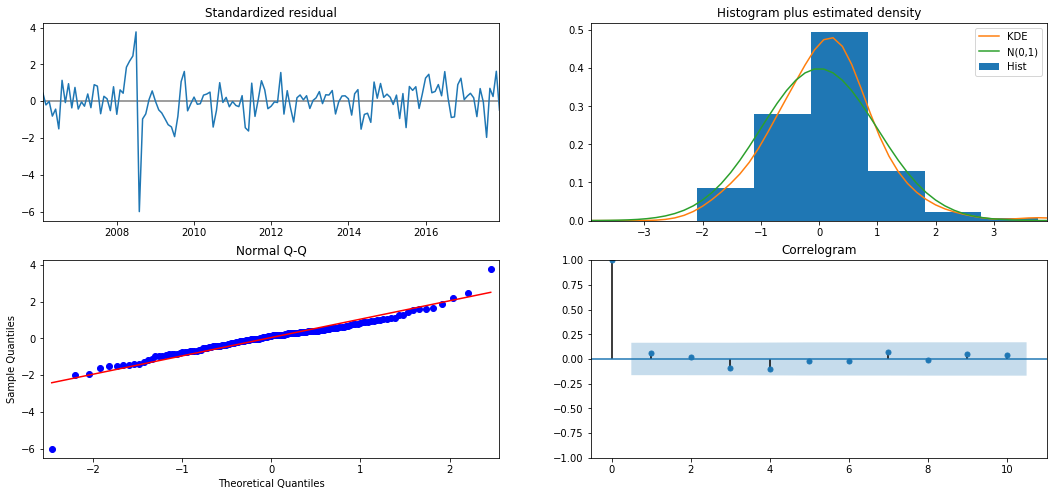

In [15]:
#DIAGNOSTICOS DEL MODELO
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [21]:
#Hacemos una predicción desde 2017-02-01 a 12 periodos adelante
train = P.P.loc['2005-01-01':'2017-01-01']
test = P.P.loc['2017-01-01':]
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=12)
future_forecast

array([214.2336956 , 210.67405868, 222.91627756, 204.0666769 ,
       231.39629485, 278.38393227, 319.14478476, 170.10440241,
       143.35007392, 164.47947744, 188.5030979 , 192.42988785])

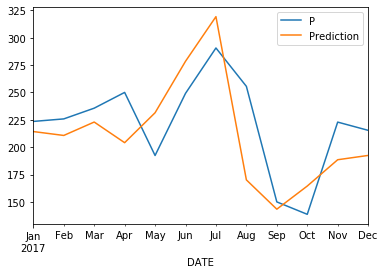

In [22]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
pd.concat([test,future_forecast],axis=1).plot()

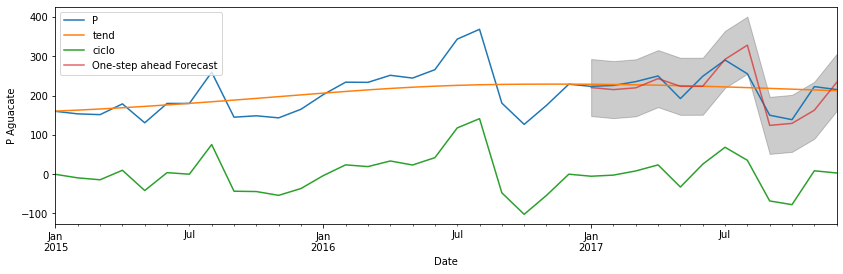

In [23]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = P.loc["2015-01-01":].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('P Aguacate')
plt.legend()
plt.show()

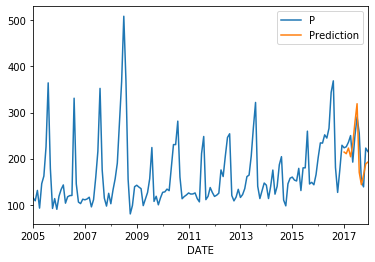

In [24]:
pd.concat([P.P,future_forecast],axis=1).plot()